In [1]:
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
current_directory = os.getcwd()
current_directory

'/Users/ruijuewang/Desktop/DFT/Sem2/FT5005 ML for Finance/Group Project/github/FT5005-Group6/Cleaned Data'

## EBITDA - LSTM Model

In [3]:
processed_df = pd.read_csv('EBITDA_new.csv')
processed_df.head()

,ticker,fiscalQuarter,commonSharesOutstanding_,commonSharesTraded_,capitalExpenditure_,netIncome_,operatingIncome_,shareholdersEquity_,totalAssets_,EPS_,...,EBITDA,salePrice,realGDPSA,m2SA,m2m1GrowthGap,m2Velocity,primeRate,EBITDA_lag1,year,quarter
0,ACAN,2013Q1,-0.000933,12.247579,0.0,-0.073272,-0.095742,-0.203545,0.0,0.0,...,50.369,13.564960,-0.867729,9.261987,0.172473,1.581,3.25,NaN,2013,1
1,ACAN,2013Q2,-0.000933,12.247579,0.0,-0.073210,-0.095754,-0.203545,0.0,0.0,...,42.617,13.651304,-0.849252,9.272702,-0.640550,1.572,3.25,50.369,2013,2
2,ACAN,2013Q3,-0.000933,12.247579,0.0,-0.073519,-0.095692,-0.203545,0.0,0.0,...,46.147,13.650265,-0.790315,9.286502,-0.328302,1.571,3.25,42.617,2013,3
3,ACAN,2013Q4,-0.000933,12.247579,0.0,-0.072407,-0.095729,-0.203541,0.0,0.0,...,67.587,13.978878,-0.729457,9.305890,-1.494308,1.563,3.25,46.147,2013,4
4,ACAN,2014Q1,-0.000933,12.247579,0.0,-0.073519,-0.095692,-0.203550,0.0,0.0,...,70.192,13.796973,-0.753759,9.321372,-1.579023,1.539,3.25,67.587,2014,1


In [4]:
# processed_df['EBITDA_lag2'] = processed_df.groupby('ticker')['EBITDA'].shift(2)

# processed_df['salePrice_lag1'] = processed_df.groupby('ticker')['salePrice'].shift(1)
# processed_df['realGDPSA_lag1'] = processed_df.groupby('ticker')['realGDPSA'].shift(1)
# processed_df['m2SA_lag1'] = processed_df.groupby('ticker')['m2SA'].shift(1)
# processed_df['m2MinusM1SA_lag1'] = processed_df.groupby('ticker')['m2MinusM1SA'].shift(1)
# processed_df['m2Velocity_lag1'] = processed_df.groupby('ticker')['m2Velocity'].shift(1)
# processed_df['primeRate_lag1'] = processed_df.groupby('ticker')['primeRate'].shift(1)

# processed_df['EBITDA_diff'] = processed_df.groupby('ticker')['EBITDA'].pct_change()
# processed_df['salePrice_diff'] = processed_df.groupby('ticker')['salePrice'].pct_change()
# processed_df['realGDPSA_diff'] = processed_df.groupby('ticker')['realGDPSA'].pct_change()
# processed_df['m2SA_diff'] = processed_df.groupby('ticker')['m2SA'].pct_change()
# processed_df['m2MinusM1SA_diff'] = processed_df.groupby('ticker')['m2MinusM1SA'].pct_change()
# processed_df['m2Velocity_diff'] = processed_df.groupby('ticker')['m2Velocity'].pct_change()
# processed_df['primeRate_diff'] = processed_df.groupby('ticker')['primeRate'].pct_change()

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2025-04-29 09:01:41.106281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Select features and target variable
# features exclude: 
features = [col for col in processed_df.columns if col not in [ 'EBITDA', 'ticker', 'companyName','fiscalQuarter']]
target = 'EBITDA'

# Remove missing values
processed_df = processed_df.dropna(subset=features + [target])

# Split the dataset based on year

train_df = processed_df[processed_df['year'] <= 2020]
test_df = processed_df[processed_df['year'] > 2020]

# Define train and test sets for scaling
X_train_raw = train_df[features]
y_train_raw = train_df[target].values.reshape(-1, 1)
X_test_raw = test_df[features]
y_test_raw = test_df[target].values.reshape(-1, 1)

# Scale the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train_raw)
y_train_scaled = scaler_y.fit_transform(y_train_raw)
X_test_scaled = scaler_X.transform(X_test_raw)
y_test_scaled = scaler_y.transform(y_test_raw)

In [8]:
# Convert to supervised learning format
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

In [9]:
# Create sequences
seq_length = 10
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, seq_length)

# Create sequences for test data
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, seq_length)

print(f'X_train shape: {X_train.shape}') 
print(f'y_train shape: {y_train.shape}')

X_train shape: (373, 10, 25)
y_train shape: (373, 1)


In [10]:
import tensorflow.keras.backend as K
import tensorflow as tf

def r2_keras(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

In [11]:
# Build model

import tensorflow as tf
import random

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds(42)

# model = Sequential([
#     LSTM(30, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dropout(0.2),
#     LSTM(30),
#     Dropout(0.2),
#     Dense(1)
# ])

model = Sequential([
    LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
]) 

model.compile(optimizer='adam', loss='mse')
# model.compile(optimizer='adam', loss='mse', metrics=[r2_keras])

X_val = X_test.copy()
y_val = y_test.copy()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


# history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.1230 - val_loss: 0.1023
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0687 - val_loss: 0.0803
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0397 - val_loss: 0.0607
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0360 - val_loss: 0.0742
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0254 - val_loss: 0.0547
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0263 - val_loss: 0.0559
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0241 - val_loss: 0.0513
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0265 - val_loss: 0.0515
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0208 - val_loss: 0.0506
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0190 - val_loss: 0.0500
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0171 - val_loss: 0.0501
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - l

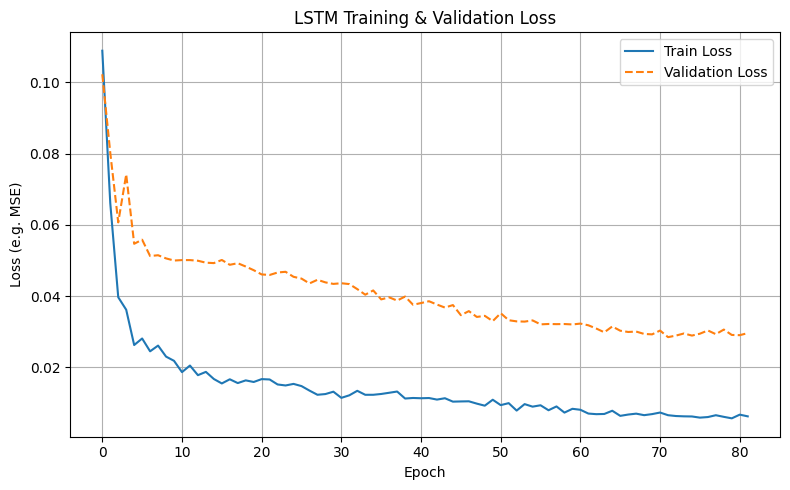

In [12]:
import matplotlib.pyplot as plt

# 画 Loss 曲线
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('LSTM Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (e.g. MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# plt.figure(figsize=(8, 5))
# plt.plot(history.history['r2_keras'], label='Train R2')
# plt.plot(history.history['val_r2_keras'], label='Validation R2', linestyle='--')
# plt.title('LSTM Training & Validation R2')
# plt.xlabel('Epoch')
# plt.ylabel('R2')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train RMSE: 268.2732
Train R2: 0.9496


Text(0.5, 1.0, 'Train Prediction vs Ground Truth')

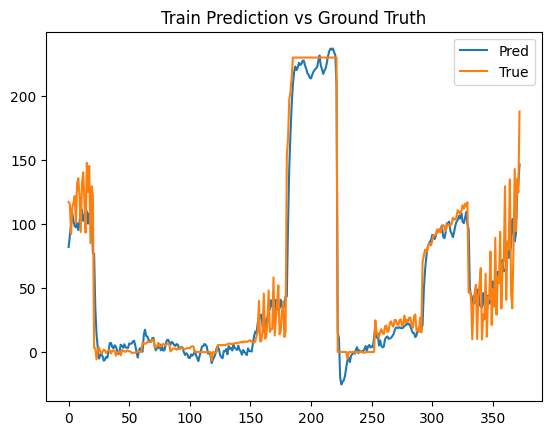

In [16]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_train)
y_train_inv = scaler_y.inverse_transform(y_train)
y_pred_inv = scaler_y.inverse_transform(y_pred)

mse = mean_squared_error(y_train_inv, y_pred_inv)
r2 = r2_score(y_train_inv, y_pred_inv)
print(f"Train RMSE: {mse:.4f}")
print(f"Train R2: {r2:.4f}")

plt.plot(y_pred_inv, label='Pred')
plt.plot(y_train_inv, label='True')
plt.legend()
plt.title("Train Prediction vs Ground Truth")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test MSE: 1592.9705
Test R2: 0.7454


Text(0.5, 1.0, 'Test Prediction vs Ground Truth')

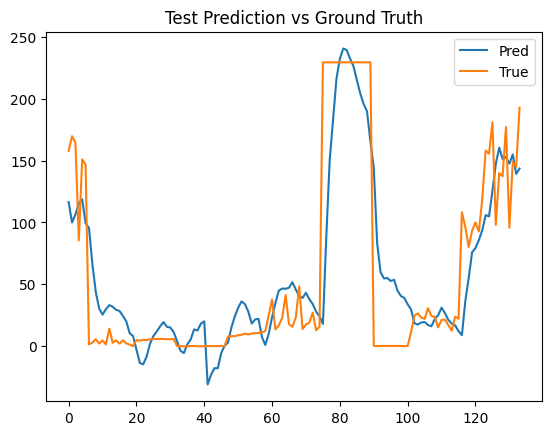

In [15]:
# Predict and evaluate
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"Test MSE: {mse:.4f}")
print(f"Test R2: {r2:.4f}")

plt.plot(y_pred_inv, label='Pred')
plt.plot(y_test_inv, label='True')
plt.legend()
plt.title("Test Prediction vs Ground Truth")